<h1> 0/ Introduction </h1>

Bonjour,

Bienvenue dans le tutoriel pour s'initier aux réseaux de neurones.
Les fonctions proposées ici servent à simplifier l'initiation et aider les radiologues motivés à mettre le pied à l'étrier

Quelques bases en python sont conseillées mais vous n'en aurez pas besoin si vous vous contentez de suivre ce tutoriel.

Pour lancer un bout de code, cliquez dessus et tappez sur ctrl + Entrée sur votre clavier


In [1]:
"""
Ceci permet d'importer les fonctions nécessaires pour la suite, celles des APIs que nous avons installées
et celle que nous proposons pour ce tutoriel.
"""
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pydicom
import os
import pandas
from PIL import Image
import random
import datetime
import scipy
import openpyxl
import time
import glob
import pathlib


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K

import FunctionsMaster  as Tutoriel

<h1> 1/ Obtention d'un Dataset </h1>

<h2> 1A/ Création d'un dataset personnel </h2>

Pour entrainer votre réseau de neurones vous devez obtenir un dataset.
Nous vous conseillons à terme de créer vos propres données, nous fournissons plusieurs fonctions pour cette tache, 
dont la principale :
    # Dossier_DICOM_vers_ImagesPNG ( DossierDICOM , Dossier_de_sauvegarde )
    
Pour l'utiliser vous devez rentrer le dossier où se situent les fichiers DICOM à la place de "DossierDICOM" et le dossier où sauvegarder les images à la place de "Dossier_de_sauvegarde".


In [2]:
"""
Si tous les fichiers sont à la racine du dossier que vous indiquez, il suffit d'utiliser la fonction telle quelle, 
en changeant le chemin vers les dosiers pour adapter à vos conditions
"""

Tutoriel.Dossier_DICOM_vers_ImagesPNG ( r"C:\Users\alexandre\IA\DossierDICOMs" , r"C:\Users\alexandre\IA\DossierIMAGESpng" )

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:\\Users\\alexandre\\IA\\DossierDICOMs'

In [ ]:
"""
Si les fichiers sont dans des sous dossiers au sein du dossier que vous indiquez, il suffit d'utiliser la fonction telle quelle, 
en changeant le chemin vers les dosiers pour adapter à vos conditions
"""

Liste_des_sous_dossiers = Tutoriel.fast_scandir(r"C:\Users\alexandre\IA\DossierDICOMs")

for sousDossier in Liste_des_sous_dossiers :
    Tutoriel.Dossier_DICOM_vers_ImagesPNG (sousDossier, r"C:\Users\alexandre\IA\DossierIMAGESpng" )

<h2> 1B/ Téléchargement d'un dataset public </h2>

Pour notre exemple nous utiliserons un dataset de radiographies thoraciques, permettant de reconnaitre :
    les radiographies normales 
    vs Pneumonie 
    vs Pneumonie Covid.
    
Le dataset est téléchargeable via ce lien : https://www.kaggle.com/tawsifurrahman/covid19-radiography-database/download
sur la page Kaggle du dataset : https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

Trions à la main le dataset en deux dossiers :
- un d'entrainement et de validation
- un de test

Dans chaque dossier nous créeons 3 sous dossiers, un pour chaque catégorie. Attention à ce que le nom des sous-dossiers corresponde.
Il est conseillé de garder une proportion globalement identique.

Nous choisissons (arbitrairement) de diviser le dataset en 80/20 : 
- 80% pour l'entrainement
- 20% le test

Voici donc la structure des dossiers à suivre :
- ...\Train_Val\Covid\ : 175 images
- ...\Train_Val\Normal\ : 1073 images
- ...\Train_Val\ViralPneumonia\ : 1076 images
- ...\Test\Covid\ : 44 images
- ...\Test\Normal\ : 268 images
- ...\Test\ViralPneumonia\ : 269 images

<h1> 2/ Lecture du Dataset </h1>

In [2]:
"""
Nous allons commencer par indiquer le chemin vers les différents dossiers de notre dataset
Pensez à changer le nom des dossiers par les votres
"""
Dossier_Train_et_validation = r"D:\These\IA\PublicDataset\covid19-radiography-database\COVID-19 Radiography Database\Tutoriel\Train_Val"
Dossier_test                = r"D:\These\IA\PublicDataset\covid19-radiography-database\COVID-19 Radiography Database\Tutoriel\Test"

DS_Train_Val = pathlib.Path(Dossier_Train_et_validation)
DS_Test      = pathlib.Path(Dossier_test)


In [3]:
"""
vérifions que les catégories ont bien été interprétées
"""
CLASS_NAMES = np.array([item.name for item in DS_Train_Val.glob('*')])
print(CLASS_NAMES)

['Covid' 'Normal' 'ViralPneumonia']


In [4]:
"""
Indiquons les réglages suivants, ils seront utilisés tout le long de notre tutoriel
"""

#De la taille des images (le logiciel modifiera automatiquement les images à cette taille.)
#Une image plus grande a plus de détail mais est plus lourde, consommant plus de ressources informatiques
Hauteurimage = 512
LargeurImage = 512
NombreChannels = 1 #Grayscale =1, couleur =3
#Donc nos images correspondent à :
IMG_SHAPE = (Hauteurimage,LargeurImage, NombreChannels)

#Du nombre d'image que notre ordinateur travaillera en parallèle
#Cela correspond au débit du 'pipeline' de notre generator
BATCH_SIZE = 4

#Du nombre d'epochs
#c'est à dire le nombre de fois que notre dataset sera transmis au réseau de neurones pour l'entrainement
EPOCHS = 15

In [5]:
"""
Créons les pipelines pour la data-augmentation
"""

#Définissons les réglages de la data augmentation voulue
data_gen_args = dict(rotation_range=15.,
                     horizontal_flip = True,
                     vertical_flip = False,
                     width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=0.5,
                     fill_mode = 'nearest',
                     validation_split = 0.25, #Permet la séparation automatique entre jeux d'entrainement et de validation
                     rescale = 1/255. #les images en png ont des pixels dont la valeur varie entre 0 et 255, nous ramenons cette valeur à 0-1 pour limiter les calculs nécessaires par le réseau.
                    )

image_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator(rescale = 1/255.)

seed = 42 #Ce nombre est arbitraire, vous pouvez le remplacer par ce que vous voulez, il correspond au point de départ pour les
#deux pipelines, le seul critère important est qu'ils aient le même point de départ

"""
#Nous définissons 4 generators : 
#    - un pour les images pour le jeu d’entrainement
#    - un pour les masques pour le jeu d’entrainement
#    - un pour les images pour le jeu de validation
#    - un pour les masques pour le jeu de validation
"""

training_generator   = image_datagen.flow_from_directory(DS_Train_Val,
                                                         color_mode = "grayscale",
                                                         subset = "training",
                                                         target_size=(Hauteurimage,LargeurImage),
                                                         batch_size=BATCH_SIZE,
                                                         seed=seed)

validation_generator = image_datagen.flow_from_directory(DS_Train_Val,
                                                         color_mode = "grayscale",
                                                         subset = "validation",
                                                         target_size=(Hauteurimage,LargeurImage),
                                                         batch_size=BATCH_SIZE,
                                                         seed=seed)

testing_generator    = test_datagen.flow_from_directory(DS_Test,
                                                        color_mode = "grayscale",
                                                        target_size=(Hauteurimage,LargeurImage),
                                                        batch_size=BATCH_SIZE,
                                                        seed=seed)


Found 1744 images belonging to 3 classes.
Found 580 images belonging to 3 classes.
Found 581 images belonging to 3 classes.


<h1> 3/ Création du Réseau de neurones </h1>

In [8]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"],
                                          cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [9]:
model = None #Cette ligne simple s'assure d'éviter un bug dans le cas où vous utilisierez cette fonction plusieurs fois
"""
Nous proposons une fonction prête à l'emploi pour créer un réseau basique de labellisation.
Bien entendu il existe de multiples facons de créer un réseau et nous vous conseillons fortement d'aller faire vos propres
essais, en vous inspirant de notre code ou de la littérature
"""

#Nous créons notre réseau 'model' à partir de la fonction toute faite
#Elle affichera automatiquement le contenu du réseau que nous avons créé :
with strategy.scope():
    model = Tutoriel.build_cnn (IMG_SHAPE, #Cela correspond à la taille des fichiers que le réseau recoit en entrée, soit nos images
                                sortie =3, #Le nombre de catégories prévues, ici 3 pour Normal, Pneumonie et Covid
                                #tous les réglages suivants sont optionnels, la fonction peut fonctionner avec uniquement les 
                                #réglages d'entrée et de sortie !!
                                optimizer            = "Adam",   #parmi 
                                Learning_rate_custom = 0.0001,
                                nombre_de_blocs      = 4,
                                feature_maps         = 32,
                                Kernel_size          = 5,
                                activation           = "selu",
                                dropout_rate         = .5,
                                batch_Norm           = True,
                                couche_entierement_connectee = 64
                               )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 508, 508, 32)      832       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 504, 504, 32)      25632     
_________________________________________________________________
batch_normalization_4 (Batch (None, 504, 504, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 252, 252, 32)      0         
_________________________________________________________________
alpha_dropout_5 (AlphaDropou (None, 252, 252, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 248, 248, 64)      51264     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 244, 244, 64)     

<h1> 4/ Entrainement du Réseau de neurones </h1>

In [10]:
"""
La fonction 'fit' déclenche l'entrainement.
Il faut indiquer les datasets d'entrainement et de valdiation, dans notre cas leur generator respectif
Le nombre d'epochs
Le nombre d'étapes nécessaires pour faire passer tout le dataset en fonction de la taille du Batch.
"""

TRAIN_STEPS_SIZE_TEST = training_generator.n   // training_generator.batch_size
VAL_STEPS_SIZE_TEST   = validation_generator.n // validation_generator.batch_size


history = model.fit(training_generator,
                    steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                    epochs=EPOCHS,
                    validation_steps=VAL_STEPS_SIZE_TEST,
                    validation_data=validation_generator)

#history : la fonction enregistre dans cette donnée la qualités des résultats au cours du temps

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 436 steps, validate for 145 steps
Epoch 1/15
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 28 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
436/436 [==============================] - 100s 229ms/step - loss: 0.6092 - accuracy: 0.6609 - val_loss: 1.1902 - val_accuracy: 0.6201
Epoch 2/15
436/436 [==============================] - 67s 154ms/step - loss: 0.5502 - accuracy: 0.6667 - val_loss: 1.0287 - val_accuracy: 0.5770
Epoch 3/15
436/436 [==============================] - 67s 154ms/step - loss: 0.5500 - accuracy: 0.6667 - val_loss: 1.1020 - val_accuracy: 0.5925
Epoch 4/15
436/436 [==============================] - 67s 153ms/step - loss: 0.5503 - accuracy: 0.6667 - val_loss: 0.9666 - val_accuracy: 0.

In [21]:
print(training_generator.classes)

[0 0 0 ... 2 2 2]


<h1> 5/ Evaluation des résultats </h1>

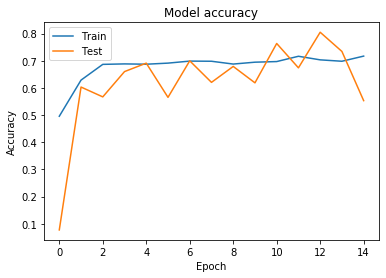

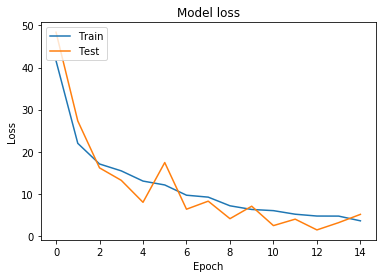

In [9]:
"""
Commencons par afficher les résultats de l'entrainement au cours du temps
"""

# Accuracy = precision = (VP + VN)/total
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Calcul de la fonction de coût (plus bas est le mieux), sa valeur dépend de son calcul et du réglage du réseau de neurones
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
"""
Le meilleur moyen pour évaluer un réseau de neurones et de le tester sur un jeu de données de test : 
des images qu'il n'a jamais vues.
Utilisons le generator que nous avons créé au départ à cet effet : 'testing_generator'
A noter que nous ne réalisons pas de modification des images dans ce generator, nous nous contentons simplement de les regarder
"""

TEST_SIZE_TEST=testing_generator.n//testing_generator.batch_size
evaluation=model.evaluate(testing_generator,steps=TEST_SIZE_TEST,verbose=1)

print(model.metrics_names[0]," : ",evaluation[0])
print(model.metrics_names[1]," : ",evaluation[1])

  ...
    to  
  ['...']
145/145 [==============================] - 10s 67ms/step - loss: 1.3010 - accuracy: 0.7638
loss  :  1.301046875731227
accuracy  :  0.7637931


8/8 [==============================] - 2s 213ms/step


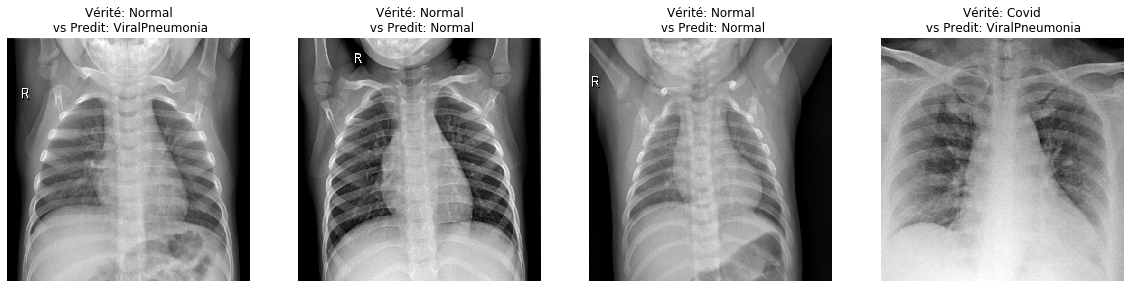

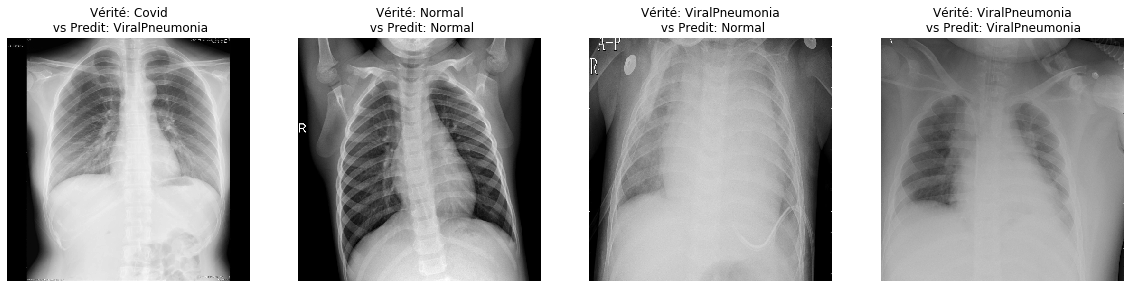

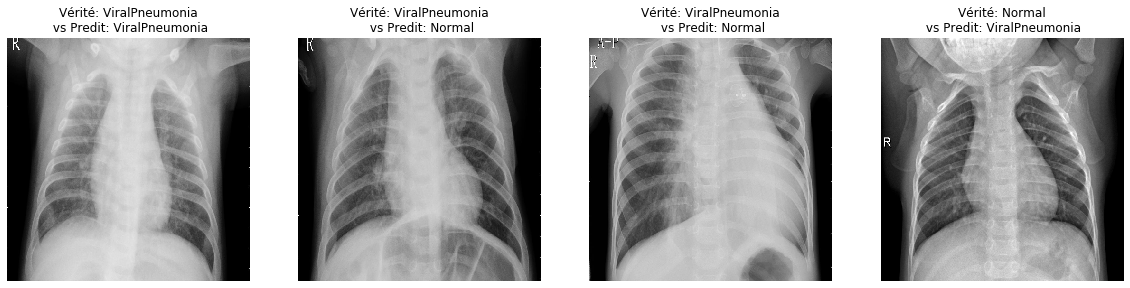

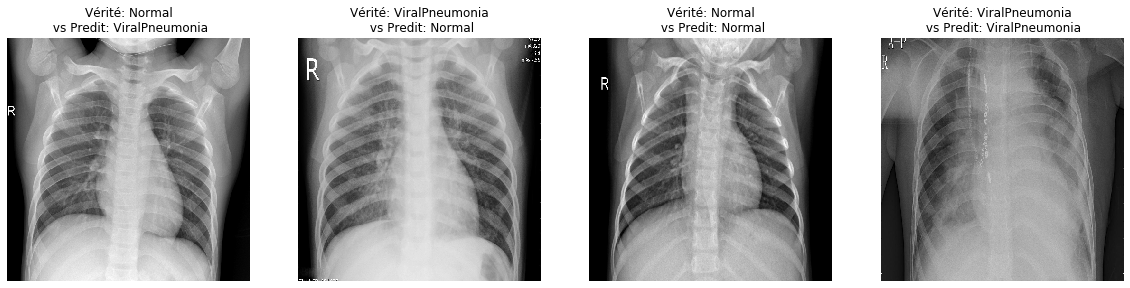

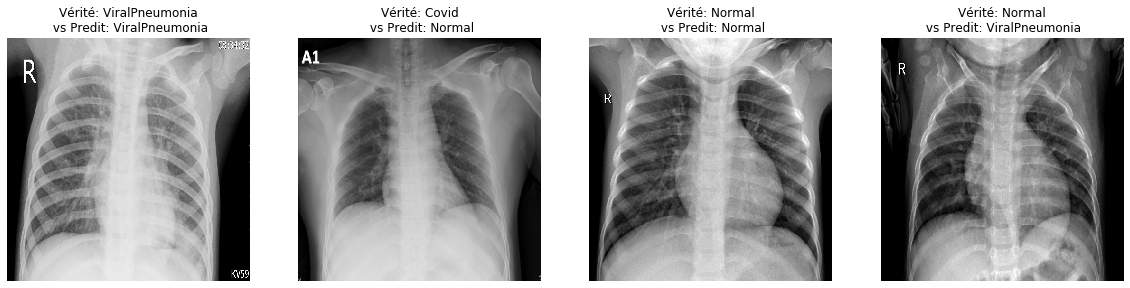

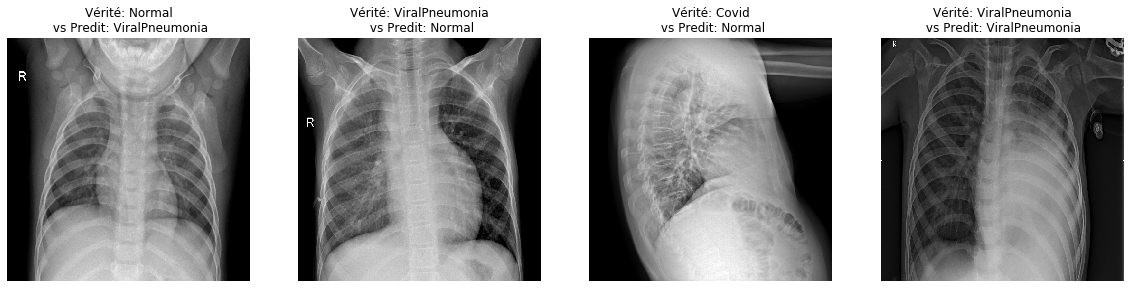

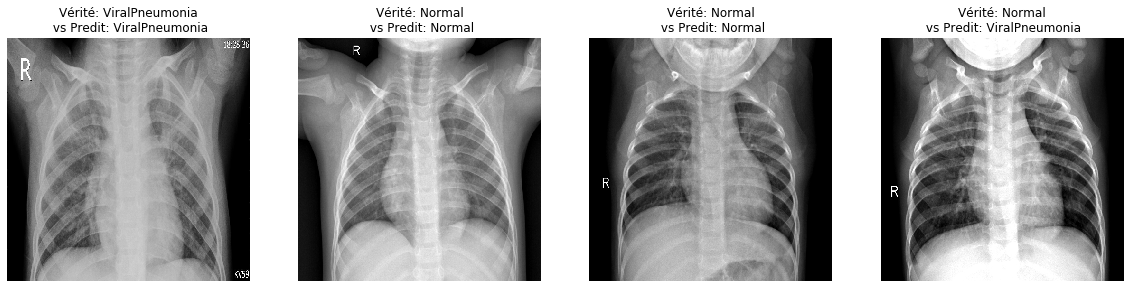

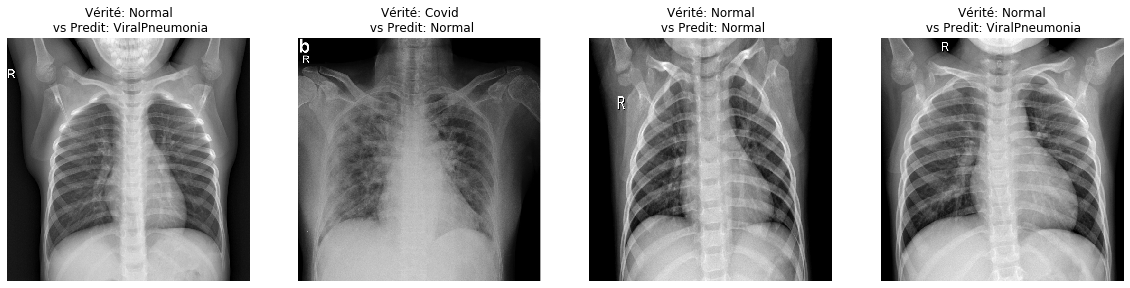

In [11]:
"""
Affichons les résultats en image avec en titre ce que le résaut a prédit et ce qu'il aurait dû prédire
Nous fournissons une fonction simple pour cet usage,
n'hésitez pas à la lancer plusieurs fois pour défiler en plusieurs fois le long du generator !
"""

Tutoriel.ComparaisonResultats(Nombre_a_afficher = 32,
                              model = model,
                              test_gen=testing_generator, 
                              categories=['Covid', 'Normal', 'ViralPneumonia'], 
                              color="gray", 
                              colonnes=4, reset=False)

<h1> 6/ Optique d'amélioration </h1>

<h2> 6a/ Correction du désiquilibre de classes </h2>

['Covid' 'Normal' 'ViralPneumonia']
Nombre total d'images : 1744
{0: 3.321904761904762, 1: 0.5417831624728177, 2: 0.540272614622057}
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 436 steps, validate for 145 steps
Epoch 1/15
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
436/436 [==============================] - 142s 325ms/step - loss: 35.9920 - accuracy: 0.4690 - val_loss: 32.4407 - val_accuracy: 0.1741
Epoch 2/15
436/436 [==============================] - 133s 306ms/step - loss: 39.5444 - accuracy: 0.5189 - val_loss: 38.1721 - val_accuracy: 0.1276
Epoch 3/15
436/436 [==============================] - 134s 306ms/step - loss: 30.9015 - accuracy: 0.5958 - val_loss: 24.5521 - val_accuracy: 0.4448

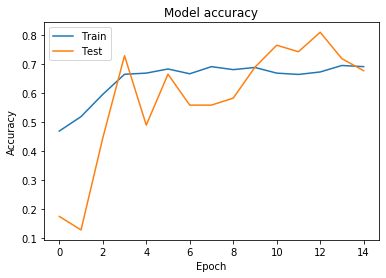

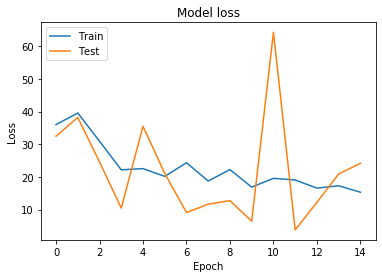

In [12]:
#Nous allons pondérer les résultats par la proportion de 3 classes, voici une méthode simple pour le faire :
total = training_generator.n
weight_for_Covid          = (1 / 175) *(total)/3.0 
weight_for_Normal         = (1 / 1073)*(total)/3.0 
weight_for_ViralPneumonia = (1 / 1076)*(total)/3.0

Ponderation = {0: weight_for_Covid, 
               1: weight_for_Normal,
               2: weight_for_ViralPneumonia}

print(CLASS_NAMES)
print("Nombre total d'images :", total)
print(Ponderation)

#Redéfinissons notre réseau de neurones puis nous l'entrainons en prenant en compte cette pondération
with strategy.scope():
    model = Tutoriel.myCNN2 (IMG_SHAPE,sortie=3,original = 32)
    
historyAvecPonderation = model.fit(training_generator,
                    steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                    epochs=EPOCHS,
                    validation_steps=VAL_STEPS_SIZE_TEST,
                    validation_data=validation_generator,
                    class_weight=Ponderation)

#Puis nous affichons ces résultats :
plt.plot(historyAvecPonderation.history['accuracy'])
plt.plot(historyAvecPonderation.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(historyAvecPonderation.history['loss'])
plt.plot(historyAvecPonderation.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
TEST_SIZE_TEST=testing_generator.n//testing_generator.batch_size
evaluation=model.evaluate(testing_generator,steps=TEST_SIZE_TEST,verbose=1)

print(model.metrics_names[0]," : ",evaluation[0])
print(model.metrics_names[1]," : ",evaluation[1])

  ...
    to  
  ['...']
145/145 [==============================] - 9s 63ms/step - loss: 57.5488 - accuracy: 0.5086
loss  :  57.548828611908284
accuracy  :  0.5086207


<h2> 6b/ Utilisation d'un autre reseau </h2> 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 436 steps, validate for 145 steps
Epoch 1/15
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = hierarchical_copy, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
436/436 [==============================] - 73s 167ms/step - loss: 1.1664 - accuracy: 0.4037 - val_loss: 2.2507 - val_accuracy: 0.4776
Epoch 2/15
436/436 [==============================] - 66s 151ms/step - loss: 0.8335 - accuracy: 0.4599 - val_loss: 7.7974 - val_accuracy: 0.4672
Epoch 3/15
436/436 [==============================] - 66s 151ms/step - loss: 0.8303 - accuracy: 0.4868 - val_loss: 8.2772 - val_accuracy: 0.4638
Epoch 4/15
436/436 [==============================] - 66s 152ms/step - loss: 0.7772 - accuracy: 0.5436 - val_loss: 7.9366 - val_accuracy: 0.6

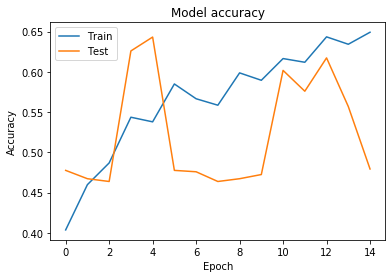

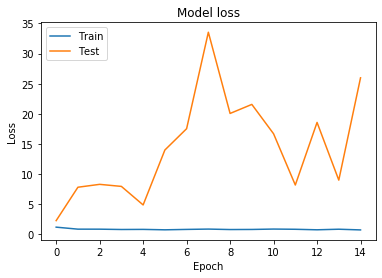

  ...
    to  
  ['...']
145/145 [==============================] - 9s 62ms/step - loss: 15.3909 - accuracy: 0.4776
loss  :  15.39090218415548
accuracy  :  0.4775862


In [17]:
with strategy.scope():
    model = mySNN (IMG_SHAPE,sortie=3)
    
historyAvecPonderation = model.fit(training_generator,
                    steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                    epochs=EPOCHS,
                    validation_steps=VAL_STEPS_SIZE_TEST,
                    validation_data=validation_generator,
                    class_weight=Ponderation)

#Puis nous affichons ces résultats :
plt.plot(historyAvecPonderation.history['accuracy'])
plt.plot(historyAvecPonderation.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(historyAvecPonderation.history['loss'])
plt.plot(historyAvecPonderation.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

TEST_SIZE_TEST=testing_generator.n//testing_generator.batch_size
evaluation=model.evaluate(testing_generator,steps=TEST_SIZE_TEST,verbose=1)

print(model.metrics_names[0]," : ",evaluation[0])
print(model.metrics_names[1]," : ",evaluation[1])

In [26]:
# Pre-trained model
base_model = tf.keras.applications.InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)
#Xception InceptionV3 ResNet50


# Freeze the pre-trained model weights
base_model.trainable = False

# Layer classification head with feature detector
Model_Verification = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalMaxPooling2D(),
    Flatten(),
    Dense(150, activation=keras.layers.LeakyReLU(alpha=0.3)),
    Dropout(0.5),
    Dense(150, activation=keras.layers.LeakyReLU(alpha=0.3)),
    Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax') #sigmoid
])


# Compile the model
Model_Verification.compile(optimizer=Adam(lr=0.0001), 
                           loss='categorical_crossentropy',
                           metrics=['accuracy']
                          )

hist1 = Model_Verification.fit(training_generator,
                               steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                               epochs=int(EPOCHS/5),
                               validation_data=validation_generator,
                               validation_steps=VAL_STEPS_SIZE_TEST,
                               #callbacks=[LearningRateReducerCb()],
                               class_weight=Ponderation)

training_generator.reset()
validation_generator.reset()



#FineTUNE

# Unfreeze all layers 
base_model.trainable = True


# Recompile the model
Model_Verification.compile(loss='categorical_crossentropy',
                           optimizer =RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.9),
                           metrics=['accuracy'])
    
# Increase training epochs for fine-tuning
hist2 = Model_Verification.fit(training_generator,
                               steps_per_epoch=TRAIN_STEPS_SIZE_TEST,
                               epochs=int(EPOCHS*4/5),
                               #callbacks=[model_checkpoint,LR_callback,LearningRateReducerCb()],
                               initial_epoch = int(EPOCHS/5),
                               validation_steps=VAL_STEPS_SIZE_TEST,
                               validation_data=validation_generator,
                               class_weight=Ponderation)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 436 steps, validate for 145 steps
Epoch 1/3
436/436 [==============================] - 157s 360ms/step - loss: 2.7752 - accuracy: 0.3589 - val_loss: 0.9161 - val_accuracy: 0.1638
Epoch 2/3
436/436 [==============================] - 149s 342ms/step - loss: 1.8920 - accuracy: 0.3733 - val_loss: 0.7480 - val_accuracy: 0.3759
Epoch 3/3
436/436 [==============================] - 146s 335ms/step - loss: 1.4642 - accuracy: 0.4558 - val_loss: 1.1516 - val_accuracy: 0.1017
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 436 steps, validate for 145 steps
Epoch 4/12
436/436 [==============================] - 158s 363ms/step - loss: 3.5606 - accuracy: 0.3888 - val_loss: 26385.4626 - val_accuracy: 0.0741
Epoch 5/12
436/436 [==============================] - 148s 340ms/step - loss: 3.6587 - accuracy: 0.4169 - val_loss: 41.0512 - val_accuracy: 0.4621
Epoch 6/12
436/436 [==============================] - 148s 340ms/step - loss: 2.